# Trilogy color images

https://github.com/dancoe/trilogy

Here we create JWST NIRCam color images of the galaxy cluster WHL0137 lensing the Sunrise Arc and Earendel.  
https://cosmic-spring.github.io/earendel.html

Zoomable / downloadable full color image:  
https://www.easyzoom.com/imageaccess/126a44c2acae47df81bee5c85c98d4c7

created using Gabriel Brammer's grizli reduced images:   
https://s3.amazonaws.com/grizli-v2/JwstMosaics/whl0137/arc-v2/index.html

Trilogy uses log scaling constrained at three points (hence the name "tri-log"-y).  
The functional form used to accomplish this is y = log10( k * (x - x0) + 1 ) / r.

The three points are (by default / for example):
- noise floor = mean - 2-sigma -> 0 (black)
- the noise = mean + 1-sigma -> 0.12 ("noiselum")
- 0.1% of pixels saturated -> 1 (white)

if setting input parameters as follows:

In [1]:
import numpy as np
import os
from glob import glob
from copy import deepcopy
from os.path import join
from os.path import expanduser
home = expanduser("~")

import astropy  # version 4.2 is required to write magnitudes to ecsv file
import astropy.io.fits as pyfits
from astropy.io import fits
import astropy.wcs as wcs
from astropy.table import QTable, Table
import astropy.units as u
from astropy.visualization import make_lupton_rgb, SqrtStretch, LogStretch, LinearStretch, hist
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.coordinates import SkyCoord
from astropy.stats import sigma_clipped_stats

from importlib import reload

In [2]:
from PIL import Image, ImageDraw, ImageFont, ImageEnhance
from PIL.PngImagePlugin import PngInfo

In [3]:
import photutils  # for background subtraction

In [4]:
#%matplotlib inline
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt
# https://matplotlib.org/tutorials/introductory/customizing.html
#plt.style.use('/Users/dcoe/p/matplotlibrc.txt')
plt.style.use('https://www.stsci.edu/~dcoe/matplotlibrc.txt')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.visualization import make_lupton_rgb, SqrtStretch, LogStretch, hist, simple_norm

In [5]:
# Trilogy

from scipy.optimize import golden

def da(k):
    a1 = k * (x1 - x0) + 1
    a2 = k * (x2 - x0) + 1
    a1n = a1**n
    a1n = np.abs(a1n)  # Don't want the solutions where a1 & a2 are both negative!
    da1 = a1n - a2
    k = np.abs(k)
    if k == 0:
        return da(1e-10)
    else:
        da1 = da1 / k  # To avoid solution k = 0!
    return abs(da1)

def imscale2(data, levels, y1):
    # x0, x1, x2  YIELD  0, y1, 1,  RESPECTIVELY
    # y1 = noiselum
    global n, x0, x1, x2  # So that golden can use them
    x0, x1, x2 = levels  
    if y1 == 0.5:
        k = (x2 - 2 * x1 + x0) / float(x1 - x0) ** 2
    else:
        n = 1 / y1
        k = np.abs(golden(da))
    r1 = np.log10( k * (x2 - x0) + 1)
    v = np.ravel(data)
    v = clip2(v, 0, None)
    d = k * (v - x0) + 1
    d = clip2(d, 1e-30, None)
    z = np.log10(d) / r1
    z = np.clip(z, 0, 1)
    z.shape = data.shape
    z = z * 255
    z = z.astype(np.uint8)
    return z

def clip2(m, m_min=None, m_max=None):
    # nanmin and nanmax important to ignore nan values
    # otherwise you'll get all 0's
    if m_min == None:
        m_min = np.nanmin(m)
    if m_max == None:
        m_max = np.nanmax(m)
    return np.clip(m, m_min, m_max)


# PREVIOUSLY in colorimage.py
def set_levels(data, pp, stripneg=False, sortedalready=False):
    if sortedalready:
        vs = data
    else:
        print('sorting...')
        vs = np.sort(data.flat)
    if stripneg:  # Get rid of negative values altogether!
        # This is the way I was doing it for a while
        # Now that I'm not, resulting images should change (get lighter)
        i = np.searchsorted(vs, 0)
        vs = vs[i+1:]
    else:  # Clip negative values to zero
        vs = clip2(vs, 0, None)
    ii = np.array(pp) * len(vs)
    ii = ii.astype(int)
    ii = np.clip(ii, 0, len(vs)-1)
    levels = vs.take(ii)
    #print ii, levels, vs, sort(vs)
    return levels


def determine_scaling(data, unsatpercent, noisesig=1, correctbias=True, noisefloorsig=2):
    """Determines data values (x0,x1,x2) which will be scaled to (0,noiselum,1)"""
    # Robust mean & standard deviation
    datasorted = data + 0
    datasorted[np.isnan(datasorted)]=0  # set all nan values to zero
    datasorted = np.sort(datasorted.flat)
    if datasorted[0] == datasorted[-1]:  # data is all one value
        levels = 0, 1, 100  # whatever
    else:
        data_mean, data_median, data_stddev = sigma_clipped_stats(datasorted)
        m = data_mean
        r = data_stddev
        print('%g +/- %g' % (m, r))

        if correctbias:
            x0 = m - noisefloorsig * r
        else:
            x0 = 0
        x1 = m + noisesig * r
        x2 = set_levels(datasorted, np.array([unsatpercent]), sortedalready=True)[0]
        levels = x0, x1, x2
    return levels

def stamp_extent(data, sample_size=1000, dx=0, dy=0, xc=0, yc=0):
    data_shape = data.shape
    if len(data_shape) == 2:
        ny, nx = data.shape
    else:
        ny, nx, three = data.shape
    
    if yc:
        dy = 0
    else:
        yc = int(ny / 2)
        
    if xc:
        dx = 0
    else:
        xc = int(nx / 2)
        
    ylo = yc - sample_size / 2 + dy
    yhi = yc + sample_size / 2 + dy

    xlo = xc - sample_size / 2 + dx
    xhi = xc + sample_size / 2 + dx
    
    ylo = int(np.clip(ylo, 0, ny))
    yhi = int(np.clip(yhi, 0, ny))
    xlo = int(np.clip(xlo, 0, nx))
    xhi = int(np.clip(xhi, 0, nx))
    #print(xlo, xhi, ylo, yhi)
    return xlo, xhi, ylo, yhi

#def image_stamps(data, sample_size=1000, dx=0, dy=0, xc=0, yc=0):
    #xlo, xhi, ylo, yhi = stamp_extent(data, sample_size, dx, dy)

def image_stamps(data, extent):
    xlo, xhi, ylo, yhi = extent
    stamps = data[ylo:yhi,xlo:xhi]
    return stamps

image_stamp = image_stamps

def roundint(x):
    return int(np.round(x))

def slices_extent(x, y, dx, dy=0):
    dy = dy or dx
    xlo = roundint(x-dx)
    xhi = roundint(x+dx+1)
    ylo = roundint(y-dy)
    yhi = roundint(y+dy+1)
    xslice = slice(xlo, xhi)
    yslice = slice(ylo, yhi)
    slices = yslice, xslice
    extent = xlo, xhi, ylo, yhi
    return slices, extent

In [6]:
def report_pixel_scale(image_file):
    hdu = fits.open(image_file)
    filt = extract_filter(image_file)
    imwcs = wcs.WCS(hdu[idata].header, hdu)
    data = hdu[idata].data
    ny, nx = data.shape
    # image_pixel_scale = np.abs(hdu[0].header['CD1_1']) * 3600
    image_pixel_scale = wcs.utils.proj_plane_pixel_scales(imwcs)[0] 
    image_pixel_scale *= imwcs.wcs.cunit[0].to('arcsec')
    outline = filt.ljust(6)
    outline += ' %5d x %5d pixels' % (ny, nx)
    outline += ' = %6.2f" x %6.2f"' % (ny * image_pixel_scale, nx * image_pixel_scale)
    outline += ' (%.2f" / pixel)' % image_pixel_scale
    print(outline)
    return imwcs

# Start here

In [7]:
def extract_filter(image_file):
    return os.path.basename(image_file).split('_')[0].lower().split('-')[3]
    #return image_file.split('_')[0].lower().split('-')[1]

In [8]:
#image_files_list = glob('../images/*_i2d.fits')
#image_files_list = glob('../images/*_sci.fits*')
image_files_list = glob('../images/grizli_v2/20mas/*_sci.fits*')
image_files_list = list(np.sort(image_files_list))
#image_files_list = image_files_list[-1:] + image_files_list[:-1]  # move F770W first
image_files_list

['../images/grizli_v2/20mas/sunrise-grizli-v2-f090w-clear_drc_sci.fits',
 '../images/grizli_v2/20mas/sunrise-grizli-v2-f115w-clear_drc_sci.fits',
 '../images/grizli_v2/20mas/sunrise-grizli-v2-f150w-clear_drc_sci.fits',
 '../images/grizli_v2/20mas/sunrise-grizli-v2-f200w-clear_drc_sci.fits',
 '../images/grizli_v2/20mas/sunrise-grizli-v2-f277w-clear_20mas_sci.fits',
 '../images/grizli_v2/20mas/sunrise-grizli-v2-f356w-clear_20mas_sci.fits',
 '../images/grizli_v2/20mas/sunrise-grizli-v2-f410m-clear_20mas_sci.fits',
 '../images/grizli_v2/20mas/sunrise-grizli-v2-f444w-clear_20mas_sci.fits']

In [9]:
filters = list(map(extract_filter, image_files_list))

# Remove stacked image _total_sci.fits.gz if present
exclude_total = [filt != 'total' for filt in filters]
image_files_list = list(np.array(image_files_list)[exclude_total])
filters = list(np.array(filters)[exclude_total])

image_files_dict = {}
for i, filt in enumerate(filters):
    image_files_dict[filt] = image_files_list[i]
    print(filt, image_files_dict[filt])

f090w ../images/grizli_v2/20mas/sunrise-grizli-v2-f090w-clear_drc_sci.fits
f115w ../images/grizli_v2/20mas/sunrise-grizli-v2-f115w-clear_drc_sci.fits
f150w ../images/grizli_v2/20mas/sunrise-grizli-v2-f150w-clear_drc_sci.fits
f200w ../images/grizli_v2/20mas/sunrise-grizli-v2-f200w-clear_drc_sci.fits
f277w ../images/grizli_v2/20mas/sunrise-grizli-v2-f277w-clear_20mas_sci.fits
f356w ../images/grizli_v2/20mas/sunrise-grizli-v2-f356w-clear_20mas_sci.fits
f410m ../images/grizli_v2/20mas/sunrise-grizli-v2-f410m-clear_20mas_sci.fits
f444w ../images/grizli_v2/20mas/sunrise-grizli-v2-f444w-clear_20mas_sci.fits


In [10]:
field = os.path.basename(image_files_list[0]).split('-')[0]
field = 'whl0137'
field

'whl0137'

In [11]:
#idata = 'sci'  # index where science data is
idata = 0  # index where science data is

In [12]:
# Check size of every image; they need to be the same, all pixel aligned
# Load data

image_data_dict = {}

for filt in filters:
    image_file = image_files_dict[filt]
    hdu = fits.open(image_file)
    data = hdu[idata].data
    #data = fill_stars(data)
    image_data_dict[filt] = data
    image_wcs = report_pixel_scale(image_file)

f090w  24000 x 17600 pixels = 480.00" x 352.00" (0.02" / pixel)
f115w  24000 x 17600 pixels = 480.00" x 352.00" (0.02" / pixel)
f150w  24000 x 17600 pixels = 480.00" x 352.00" (0.02" / pixel)
f200w  24000 x 17600 pixels = 480.00" x 352.00" (0.02" / pixel)
f277w  24000 x 17600 pixels = 480.00" x 352.00" (0.02" / pixel)
f356w  24000 x 17600 pixels = 480.00" x 352.00" (0.02" / pixel)
f410m  24000 x 17600 pixels = 480.00" x 352.00" (0.02" / pixel)
f444w  24000 x 17600 pixels = 480.00" x 352.00" (0.02" / pixel)


# Align images to same pixels, if needed

In [13]:
from reproject import reproject_interp  # https://reproject.readthedocs.io/en/stable/

if 0:
    reference_filter = 'f200w'
    reference_file = image_files_dict[reference_filter]
    reference_hdu = fits.open(reference_file)
    reference_header = reference_hdu[idata].header
    reference_file

    for filt in filters:
        image_file = image_files_dict[filt]
        #reprojected_file = image_file.replace('_i2d', '_sci')
        reprojected_file = image_file.replace('_drz_sci', '_20mas_sci')
        if os.path.exists(reprojected_file):
            continue

        hdu = fits.open(image_file)
        data = hdu[idata]

        print("Reprojecting...")  # 1 minute
        reprojected_data, footprint = reproject_interp(data, reference_header)

        fits.writeto(reprojected_file, reprojected_data, reference_header)
        print(reprojected_file)

# Show an image to orient yourself

<IPython.core.display.Javascript object>


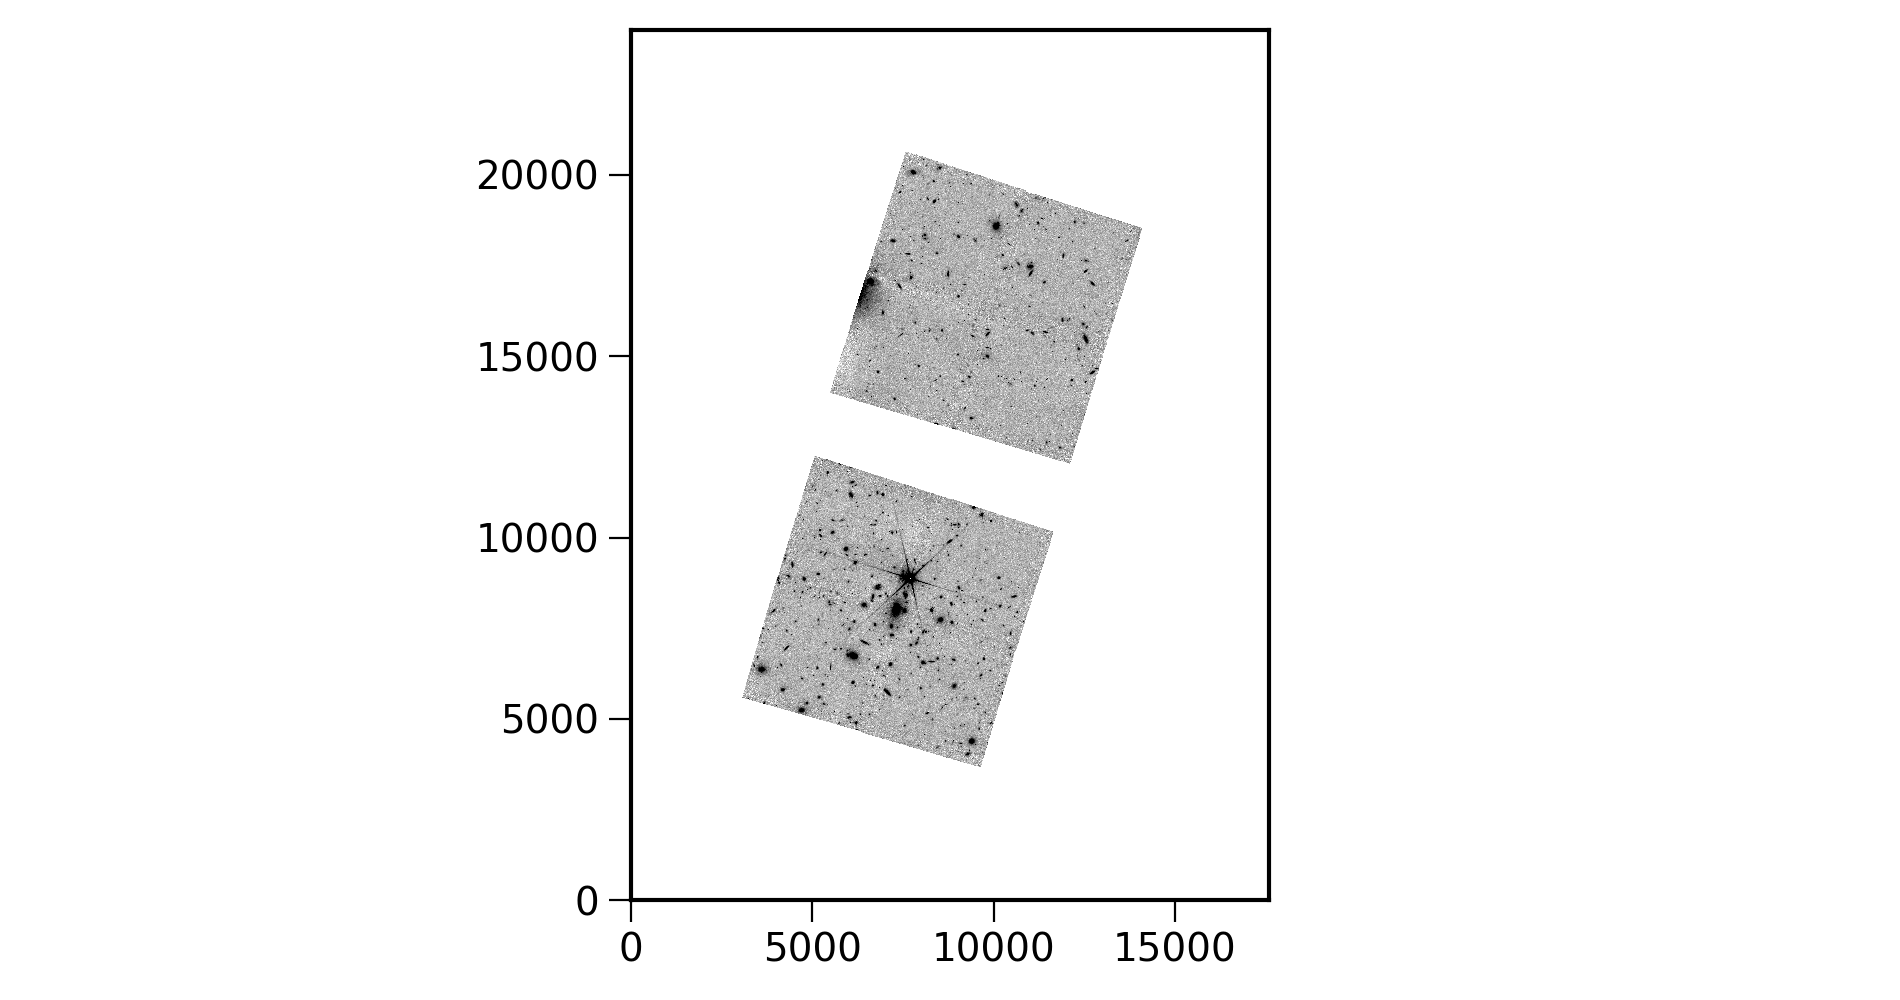

In [14]:
data = image_data_dict['f150w']

fig = plt.figure(figsize=(9.5, 5))
ax = fig.add_subplot(1, 1, 1)  # , projection=imwcs) # , sharex=True, sharey=True
data = np.where(data, data, np.nan) # Set data=nan where data=0
norm = simple_norm(data, 'sqrt', min_percent=1, max_percent=99)
plt.imshow(data, origin='lower', norm=norm, interpolation='none', cmap='Greys')

In [15]:
# Show all images
if 0:
    nrows = 2
    ncolumns = int(np.ceil(len(filters) / nrows))
    fig, ax = plt.subplots(nrows, ncolumns, figsize=(9.5,5), sharex=True, sharey=True)

    norm = ImageNormalize(stretch=SqrtStretch(), vmin=0, vmax=0.5)
    for i, filt in enumerate(filters):
        iy = i // ncolumns
        ix = i %  ncolumns
        hdu = fits.open(image_files_list[i])
        data = hdu[idata].data
        data = np.where(data, data, np.nan)  # ignore blank areas when scaling
        norm = simple_norm(data, 'sqrt', min_percent=0.1, max_percent=99.9)
        ax[iy,ix].imshow(data, origin='lower', interpolation='none', norm=norm, cmap='Greys')
        ax[iy,ix].set_title(filt)

# Sample a region of the image and make a color stamp

## A few different ways to assign colors to filters (or vice versa)

# Manual colors

In [16]:
# Long Wavelength only
out_ext = 'all_20mas'

filter_colors = {}     # R, G, B
filter_colors['f090w'] = 0.5, 0, 1
filter_colors['f115w'] = 0, 0, 1
filter_colors['f150w'] = 0, 0.5, 0.5
filter_colors['f200w'] = 0, 1, 0
filter_colors['f277w'] = 1, 0, 0
filter_colors['f356w'] = 1, 0, 0
filter_colors['f410m'] = 1, 0, 0
filter_colors['f444w'] = 1, 0, 0
filters = filter_colors.keys()
filters

dict_keys(['f090w', 'f115w', 'f150w', 'f200w', 'f277w', 'f356w', 'f410m', 'f444w'])

# Rainbow automatic colors

In [17]:
#filters = 'f090w f115w f150w f200w'.split(); out_ext = 'sw_20mas'
#filters = 'f277w f356w f410m f444w'.split(); out_ext = 'lw'

In [18]:
# I like this method to set colors for many filters
# note as implemented it does require boosting saturation after the fact

#out_ext = 'rainbow'

if 0:
    cmap = matplotlib.cm.get_cmap("rainbow")

    filter_colors = {}
    for i, filt in enumerate(filters):
        x_min = 0.0  # bluest filter will be purple
        #x_min = 0.1  # bluest filter will be blue
        x = i / (len(filters) - 1) * (1 - x_min) + x_min
        r_lum, g_lum, b_lum, alpha = cmap(x)
        rgb_lum = np.array([r_lum, g_lum, b_lum])
        filter_colors[filt] = rgb_lum
        print(filt, ' %4.2f' % r_lum, ' %4.2f' % g_lum, ' %4.2f' % b_lum)

# Define colors another way B, G, R

In [19]:
def x_rgb(x):
    # -0.25 = purple
    # 0 = blue, 0.5 = green, 1 = red
    xp = -0.25, 0, 0.5, 1
    b_lum = np.interp(x, xp, [1,   1, 0, 0])
    g_lum = np.interp(x, xp, [0,   0, 1, 0])
    r_lum = np.interp(x, xp, [0.5, 0, 0, 1])
    return r_lum, g_lum, b_lum

In [20]:
if 0:
    len(filters)
    #x0 = 0  # blue -- red
    x0 = -0.25  # purple -- red
    dx = 1 / (len(filters) - 1)
    #for x in np.arange(x0,1.01,dx):
    #    print(x, x_rgb(x))
    for i, filt in enumerate(filters):
        x = x0 + i * dx
        filter_colors[filt] = x_rgb(x)

# After assigning colors to filters

## Filter color sum

In [21]:
filters = filter_colors.keys()
print(filters)

for filt in filters:
    filter_colors[filt] = np.array(filter_colors[filt])
    
rgb_lum_sum = np.zeros(3)
for i, filt in enumerate(filters):
    rgb_lum_sum += np.array(filter_colors[filt])
    
rgb_lum_sum

dict_keys(['f090w', 'f115w', 'f150w', 'f200w', 'f277w', 'f356w', 'f410m', 'f444w'])


array([4.5, 1.5, 2.5])

## Set parameters and iterate until it looks good

In [22]:
# Input parameters

#sample_size = 1000
sample_size = 800

dx = dy = 0  # don't use offset
xc, yc = 8400, 6400  # Sunrise Arc 20mas

noiselum   = 0.12  # brightness of "the noise"
satpercent = 0.01  # percentage of pixels allowed to saturate (e.g., to white)
unsatpercent = 1 - 0.01 * satpercent

noisesig = 1  # set e.g., 1-sigma noise to noiselum 
correctbias = True  ## yes because need to dip below 0 by noisefloorsig-sigma
noisefloorsig = 1  #  set black to e.g., 2-sigma below 
# previously noisesigbias

color_saturation = 1.5  # increase color saturation > 1

# Scale images and make color image stamp

In [25]:
scaled_images = {}
levels_all = {}
for filt in filters:
    data = image_data_dict[filt]
    #data = background_subtracted_dict[filt]
    print(filt, data.shape)
    my_stamp_extent = stamp_extent(data, sample_size, dx, dy, xc, yc)
    stamp = image_stamp(data, my_stamp_extent)
    levels = determine_scaling(stamp.ravel(), unsatpercent, noisesig, correctbias, noisefloorsig)
    scaled = imscale2(stamp, levels, noiselum)
    levels_all[filt] = levels
    scaled_images[filt] = scaled
    
rgb_total = 0
for filt in filters:
    rgb = r, g, b = filter_colors[filt][:, np.newaxis, np.newaxis] * scaled_images[filt]
    #imrgb = np.array([r, g, b]).transpose((1,2,0)).astype(np.uint8)    
    rgb_total = rgb_total + rgb
    
r, g, b = rgb_average = rgb_total / rgb_lum_sum[:, np.newaxis, np.newaxis]

imrgb = np.array([r, g, b]).transpose((1,2,0)).astype(np.uint8)

if 0:
    fig, ax = plt.subplots(1, 1, figsize=(9.5, 6))
    plt.imshow(imrgb, origin='lower', extent=my_stamp_extent) # (xlo,xhi,ylo,yhi))
else:
    im = Image.fromarray(imrgb, 'RGB')
    im = im.transpose(method=Image.Transpose.FLIP_TOP_BOTTOM)
    if color_saturation > 1:
        im = ImageEnhance.Color(im).enhance(color_saturation)
    im.show()

f090w (24000, 17600)
0.000669111 +/- 0.0233383
f115w (24000, 17600)
0.000755286 +/- 0.0215911
f150w (24000, 17600)
0.00303893 +/- 0.0185455
f200w (24000, 17600)
0.00244304 +/- 0.0169374
f277w (24000, 17600)
0.0121232 +/- 0.03171
f356w (24000, 17600)
0.00877306 +/- 0.0273772
f410m (24000, 17600)
0.0046103 +/- 0.0416704
f444w (24000, 17600)
0.00582057 +/- 0.0301018


<IPython.core.display.Javascript object>


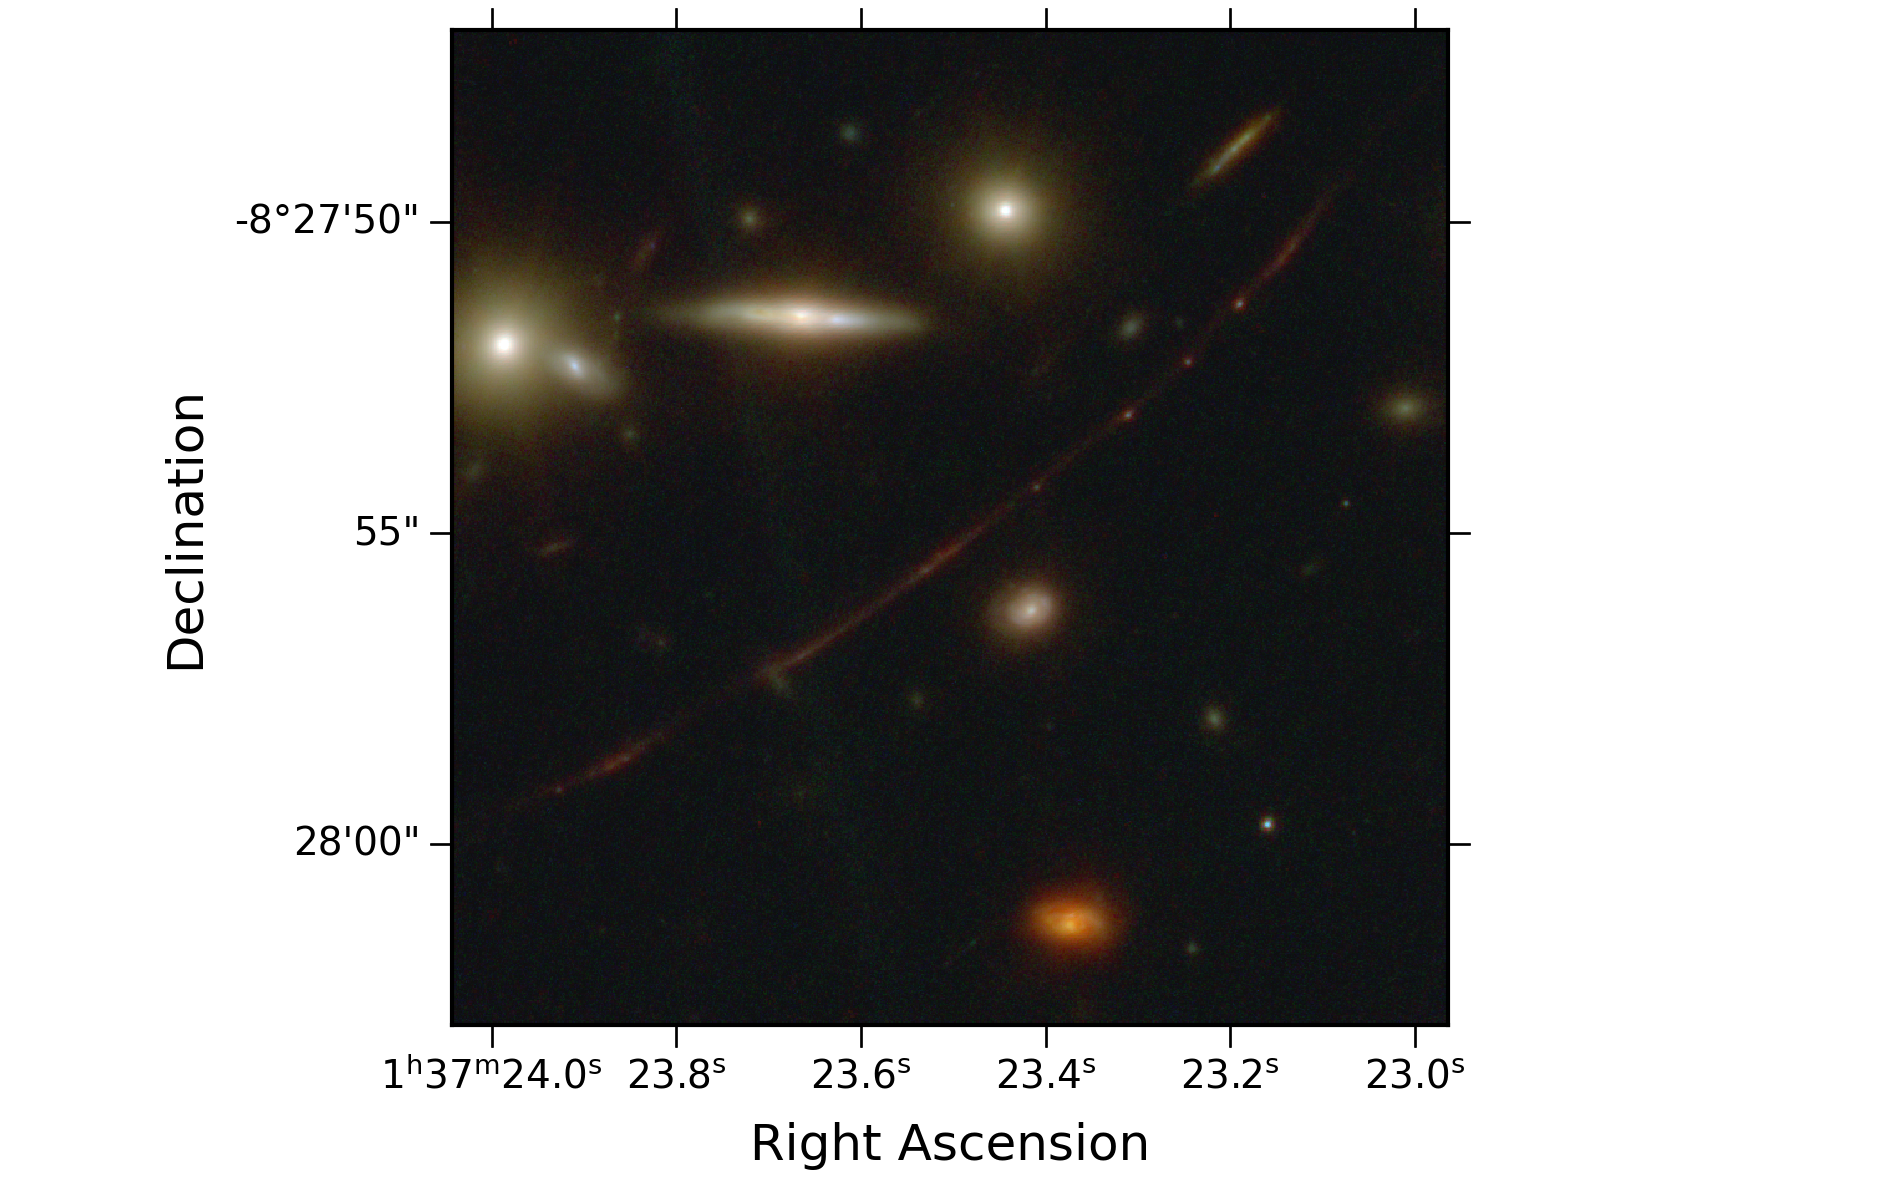

In [26]:
color_image = np.asarray(im)[::-1]

fig = plt.figure(figsize=(9.5, 6))
ax = fig.add_subplot(1, 1, 1, projection=image_wcs) # , sharex=True, sharey=True)
plt.imshow(color_image)#, origin='lower')
plt.imshow(color_image, origin='lower', interpolation='none', extent=my_stamp_extent)
plt.xlabel('Right Ascension')
plt.ylabel('Declination')

# (Optional) Show filter image stamps in each color they're assigned

<IPython.core.display.Javascript object>


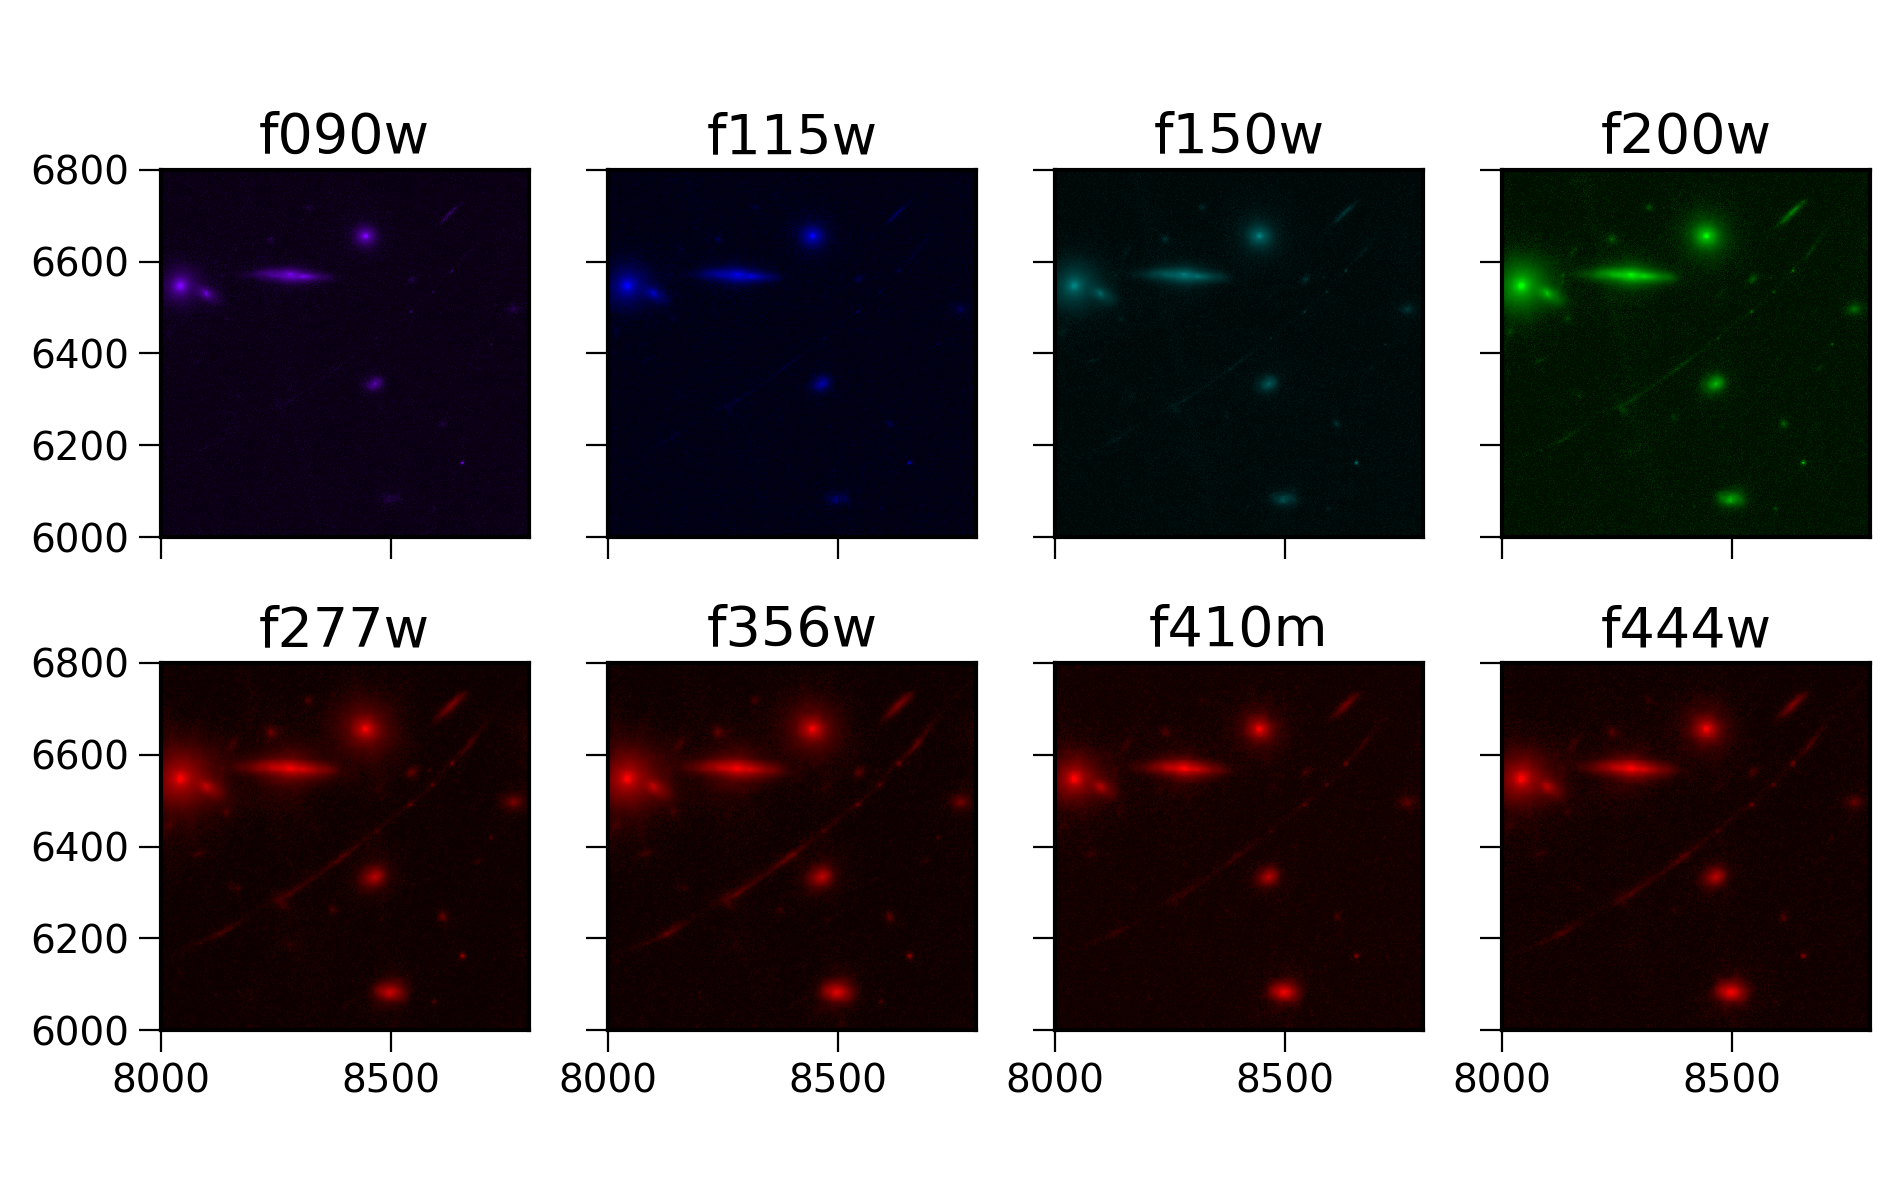

In [29]:
nrows = 2
ncolumns = int(np.ceil(len(filters) / nrows))

fig, ax = plt.subplots(nrows, ncolumns, figsize=(9.5,6), sharex=True, sharey=True)
ax = ax.flatten()

for i, filt in enumerate(filters):
    r, g, b = filter_colors[filt][:, np.newaxis, np.newaxis] * scaled_images[filt]
    imrgb = np.array([r, g, b]).transpose((1,2,0)).astype(np.uint8)
    ax[i].imshow(imrgb, origin='lower', interpolation='none', cmap='Greys_r', extent=my_stamp_extent)
    ax[i].set_title(filt)

## Once you're happy with the color image stamp,
# Create and save the full color image

may take a few minutes for large images

In [30]:
#out_ext = ''
out_ext

'all_20mas'

In [31]:
scaled_images = {}
for filt in filters:
    data = image_data_dict[filt]
    #data = background_subtracted_dict[filt]
    levels = levels_all[filt]
    scaled = imscale2(data, levels, noiselum)
    scaled_images[filt] = scaled
    
rgb_total = 0
for filt in filters:
    rgb = r, g, b = filter_colors[filt][:, np.newaxis, np.newaxis] * scaled_images[filt]
    rgb_total = rgb_total + rgb
    
r, g, b = rgb_average = rgb_total / rgb_lum_sum[:, np.newaxis, np.newaxis]

imrgb = np.array([r, g, b]).transpose((1,2,0)).astype(np.uint8)
if 0:  # don't plot, just save it below
    fig, ax = plt.subplots(1, 1, figsize=(9.5, 6))
    plt.imshow(imrgb, origin='lower') # (xlo,xhi,ylo,yhi))

In [32]:
im = Image.fromarray(imrgb, 'RGB')
im = im.transpose(method=Image.Transpose.FLIP_TOP_BOTTOM)

if color_saturation > 1:
    im = ImageEnhance.Color(im).enhance(color_saturation)

In [33]:
outfile = field + '_color.png'
if out_ext:
    outfile = outfile.replace('.png', '_'+out_ext+'.png')

outfile

'whl0137_color_all_20mas.png'

## Save creation info to image meta data

https://stackoverflow.com/questions/58399070/how-do-i-save-custom-information-to-a-png-image-file-in-python

In [49]:
metadata = PngInfo()
metadata.add_text("Created with Trilogy", "https://github.com/dancoe/trilogy")
for filt in filters:
    color = filter_colors[filt]
    rgb_hex = matplotlib.colors.to_hex(color)
    metadata.add_text(filt+'_rgb', rgb_hex)

params = 'sample_size dx dy xc yc noiselum satpercent unsatpercent noisesig correctbias noisefloorsig color_saturation'.split()
for param in params:
    s = '%g' % globals()[param]
    #print(param, s)
    metadata.add_text(param, s)

for filt in filters:
    for ix in 0,1,2:
        level = levels_all[filt][ix]
        metadata.add_text(filt+'_x%d' % ix, '%g' % level)

#metadata.chunks
#load_image = Image.open(image_file)
#load_image.text

In [51]:
if os.path.exists(outfile):
    print(outfile, 'EXISTS')
else:
    print('SAVING', outfile)
    #matplotlib.image.imsave(outfile, imrgb)
    im.save(outfile, pnginfo=metadata)

SAVING whl0137_color_all_20mas.png


# OPTIONAL

# Plot color image with RA, Dec axes

In [35]:
imflip = im.transpose(method=Image.Transpose.FLIP_TOP_BOTTOM)
color_image = np.asarray(imflip)

In [39]:
xlo, xhi = 7980, 8740
ylo, yhi = 6135, 6755
extent = xlo, xhi, ylo, yhi
xslice = slice(xlo, xhi)
yslice = slice(ylo, yhi)
slices = yslice, xslice

<IPython.core.display.Javascript object>


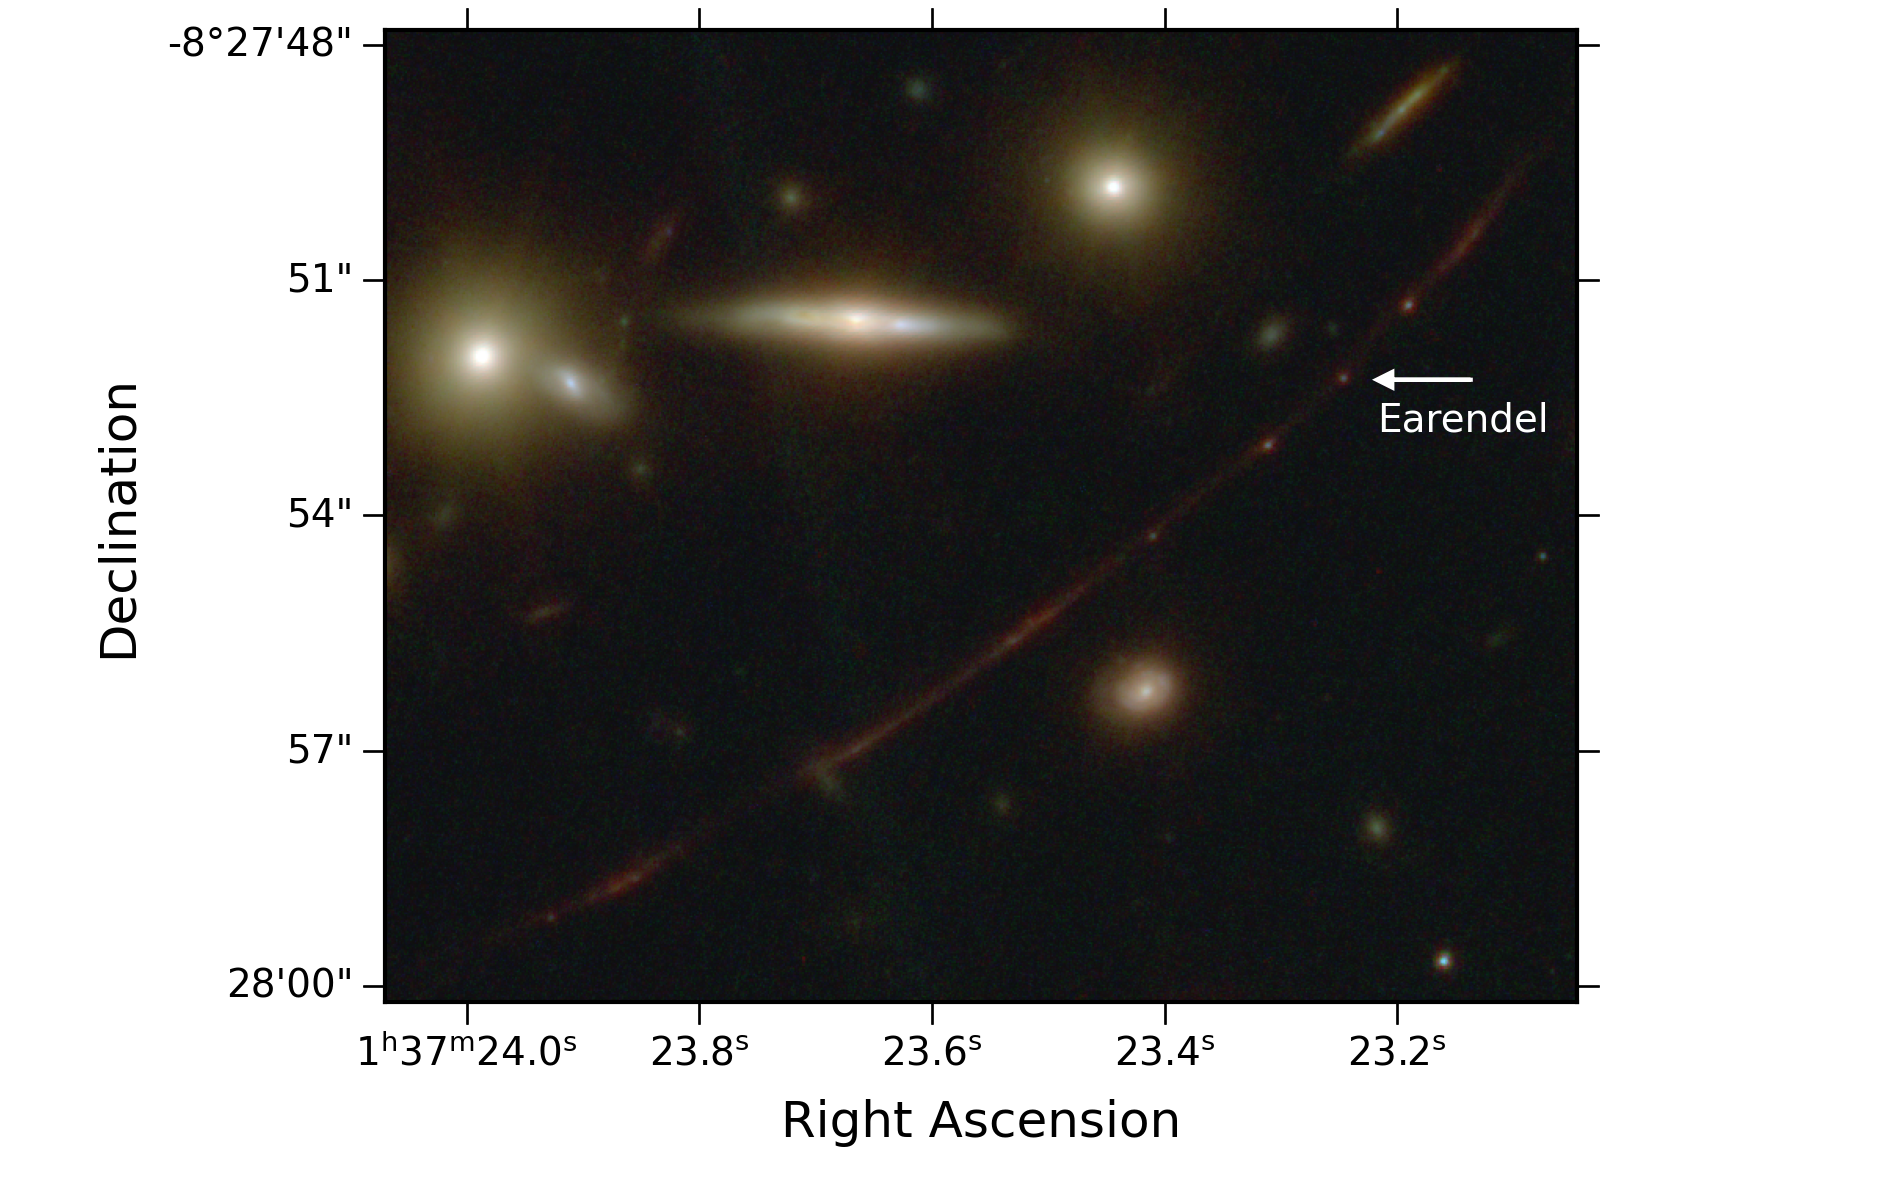

(6135.0, 6755.0)

In [44]:
fig = plt.figure(figsize=(9.5, 6))
ax = fig.add_subplot(1, 1, 1, projection=image_wcs) # , sharex=True, sharey=True)
plt.imshow(color_image[slices], extent=extent)#, origin='lower')
plt.xlabel('Right Ascension')
plt.ylabel('Declination')
plt.xlim(xlo, xhi)
plt.ylim(ylo, yhi)

## Add Annotations

In [45]:
# https://docs.astropy.org/en/stable/visualization/wcsaxes/overlays.html
ax.set_autoscale_on(False)  # freeze all motor functions

In [46]:
x, y = 8622, 6532
dx, dy = 50, 0
ax.arrow(x+dx, y, -dx, dy, head_width=10, head_length=10, lw=1.5, fc='w', ec='w')
plt.text(x-10, y-33, 'Earendel', fontsize=14, color='w');

In [47]:
plt.show()  # wait a few seconds for update to show up above

In [48]:
plt.savefig('SunriseArc_color.pdf', bbox_inches='tight', dpi=800)

/var/folders/y3/vsjr6j554mnfpgy_m1xrnckm0003tz/T/ipykernel_31743/1692017751.py:1: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.savefig('SunriseArc_color.pdf', bbox_inches='tight', dpi=800)
